# Rekomendasi Buku Berbasis Content-Based dan Collaborative Filtering

# Dataset dan Referensi

**Dataset:** [Books Dataset](https://www.kaggle.com/datasets/saurabhbagchi/books-dataset)

* Berisi lebih dari 700.000 interaksi pengguna dan 180.000+ resep
* Dua file utama digunakan:

  * `books.csv` — data buku yang ada
  * `ratings.csv` — rating yang diberikan user kepada setiap buku

# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib
import pickle
import os

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
df_books = pd.read_csv('books.csv', encoding='latin-1', delimiter=';', on_bad_lines='skip')
df_ratings = pd.read_csv('ratings.csv', encoding='latin-1', delimiter=';', on_bad_lines='skip')

# EDA

## Ekplorasi Umum

In [3]:
df_books.shape

(271360, 8)

In [4]:
df_ratings.shape

(1149780, 3)

In [5]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [7]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
df_books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,3462017942,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/155936078X.0...,http://images.amazon.com/images/P/155936078X.0...,http://images.amazon.com/images/P/155936078X.0...
freq,1,27,632,13903,7535,2,2,2


In [10]:
df_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [11]:
df_books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [12]:
df_ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [13]:
df_books.duplicated().sum()

np.int64(0)

In [14]:
df_ratings.duplicated().sum()

np.int64(0)

## Visualisasi

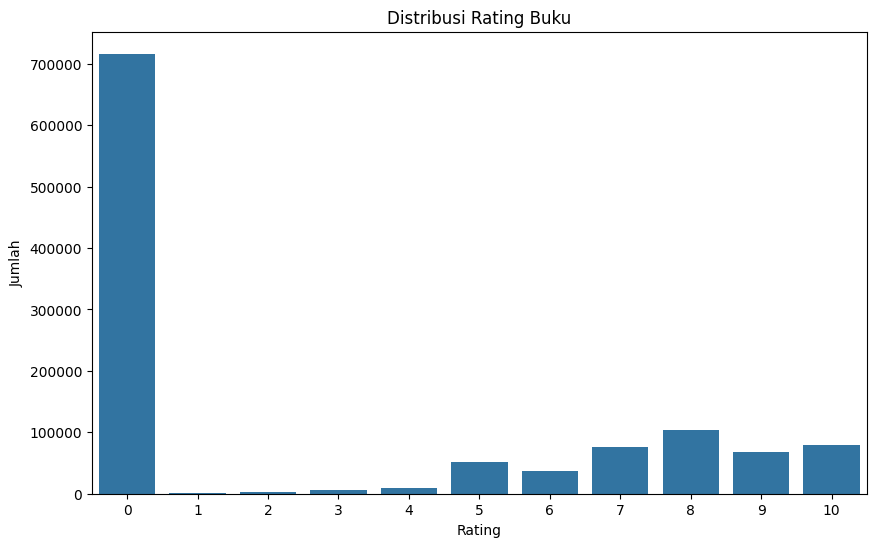

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=df_ratings)
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Banyak buku yang tidak ada rating

Top 10 Buku dengan Rata-Rata Rating Tertinggi (min 50 rating):
                                                        mean  count
Book-Title                                                         
The Two Towers (The Lord of the Rings, Part 2)      9.330882    136
The Return of the King (The Lord of the Rings, ...  9.213592    103
Harry Potter and the Goblet of Fire (Book 4)        9.125506    247
The Hobbit                                          9.120000     50
The Little Prince                                   9.111111     90
Charlotte's Web (Trophy Newbery)                    9.073529     68
Harry Potter and the Sorcerer's Stone (Book 1)      9.062500    176
84 Charing Cross Road                               9.049180     61
Harry Potter and the Order of the Phoenix (Book 5)  9.047393    211
Harry Potter and the Prisoner of Azkaban (Book 3)   9.043321    277


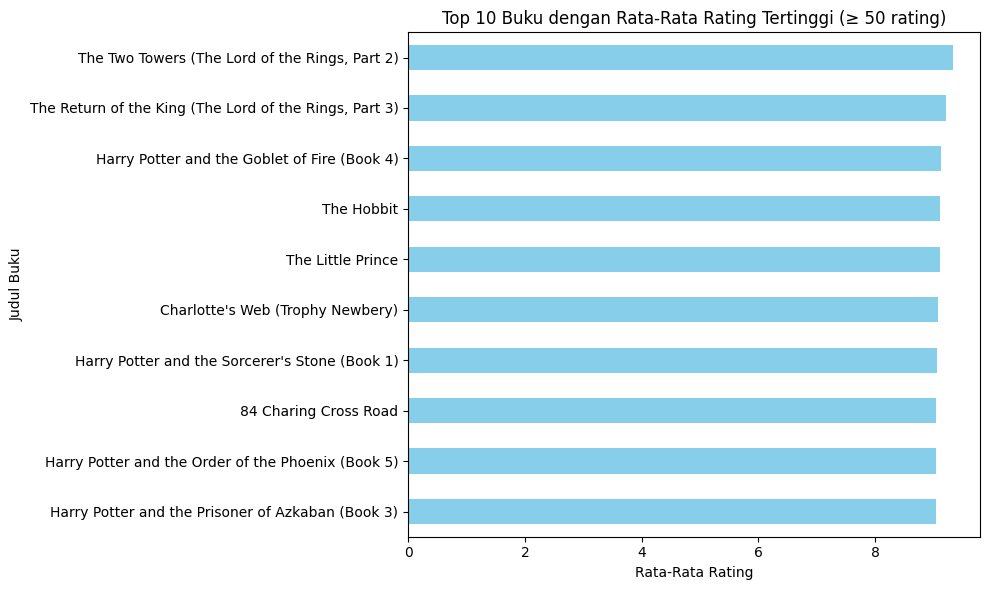

In [16]:
# Gabungkan data berdasarkan ISBN
df = df_ratings.merge(df_books, on='ISBN', how='left')

# Hanya ambil rating > 0 (rating aktual)
df_filtered = df[df['Book-Rating'] > 0]

# Hitung rata-rata dan jumlah rating per buku
avg_rating = df_filtered.groupby('Book-Title')['Book-Rating'].agg(['mean', 'count'])

# Filter buku dengan minimal 50 rating
popular_books = avg_rating[avg_rating['count'] >= 50]

# Urutkan dari rata-rata rating tertinggi
top_books = popular_books.sort_values(by='mean', ascending=False).head(10)

# Tampilkan hasil sebagai DataFrame
print("Top 10 Buku dengan Rata-Rata Rating Tertinggi (min 50 rating):")
print(top_books)

# Visualisasi
top_books['mean'].sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Buku dengan Rata-Rata Rating Tertinggi (≥ 50 rating)')
plt.xlabel('Rata-Rata Rating')
plt.ylabel('Judul Buku')
plt.tight_layout()
plt.show()

# Preprocessing

In [17]:
df_books['Year-Of-Publication'] = pd.to_datetime(df_books['Year-Of-Publication'], errors='coerce', format='%Y')

In [18]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ISBN                 271360 non-null  object        
 1   Book-Title           271360 non-null  object        
 2   Book-Author          271358 non-null  object        
 3   Year-Of-Publication  266737 non-null  datetime64[ns]
 4   Publisher            271358 non-null  object        
 5   Image-URL-S          271360 non-null  object        
 6   Image-URL-M          271360 non-null  object        
 7   Image-URL-L          271357 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 16.6+ MB


In [19]:
df_books.dropna(inplace=True)

In [20]:
df_books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

# Feature Engineering - Content-Based Representation

In [21]:
df_books['text'] = (
    df_books['Book-Title'].astype(str) + ' ' +
    df_books['Book-Author'].astype(str) + ' ' +
    df_books['Publisher'].astype(str)
).str.lower()

In [22]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_books['text'])

print(f"Shape of TF-IDF Matrix: {tfidf_matrix.shape}")

Shape of TF-IDF Matrix: (266733, 115578)


In [23]:
from sklearn.neighbors import NearestNeighbors

# TF-IDF dari sebelumnya
# tfidf_matrix = tfidf.fit_transform(df_books['text'])

# Buat model Nearest Neighbors dengan cosine distance (1 - cosine similarity)
model_nn = NearestNeighbors(metric='cosine', algorithm='brute')
model_nn.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [24]:
df_books = df_books.reset_index(drop=True)
indices = pd.Series(df_books.index, index=df_books['Book-Title'].str.lower()).drop_duplicates()

In [25]:
def recommend_fast(title, model=model_nn, tfidf_matrix=tfidf_matrix, df=df_books, top_n=10):

    title = title.lower()
    if title not in indices:
        return f"Buku '{title}' tidak ditemukan."

    idx = indices[title]
    tfidf_vector = tfidf_matrix[idx]

    distances, indices_nn = model.kneighbors(tfidf_vector, n_neighbors=top_n + 1)
    recommended_idx = indices_nn[0][1:]  # skip self

    return df[['Book-Title', 'Book-Author']].iloc[recommended_idx]


In [26]:
recommend_fast("The Hobbit")

,Book-Title,Book-Author
3301,The Hobbit,J. R. R. Tolkien
6137,The Hobbit,J R R Tolkien
62114,The Hobbit,J.R.R. TOLKIEN
111815,The Hobbit,J. R. R. Tolkien
32264,The Hobbit,J.R.R. Tolkien
187863,The Hobbit: Or There and Back Again,J. R. R. Tolkien
29970,The Hobbit: Or There and Back Again,J. R. R. Tolkien
30206,The Hobbit: Or There and Back Again,J. R. R. Tolkien
13838,Lo Hobbit / The Hobbit,J. R. R. Tolkien
39111,The Hobbit,J. R. R. Tolkien


# Collaborative Filtering

In [27]:
import numpy as np
print(np.__version__)

2.0.2


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten

# Hyperparameters
num_users = df_ratings['User-ID'].nunique()
num_books = df_books['ISBN'].nunique()
embedding_dim = 50

In [29]:
# Input layers
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))

# Embedding layers
user_embedding = Embedding(input_dim=num_users+1, output_dim=embedding_dim)(user_input)
book_embedding = Embedding(input_dim=num_books+1, output_dim=embedding_dim)(book_input)

# Dot product of embeddings
dot_product = Dot(axes=2)([user_embedding, book_embedding])
dot_product = Flatten()(dot_product)

In [30]:
model = Model(inputs=[user_input, book_input], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')

In [31]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
book_enc = LabelEncoder()

df_ratings = df_ratings[df_ratings['Book-Rating'] > 0]

df_ratings['user'] = user_enc.fit_transform(df_ratings['User-ID'])
df_ratings['book'] = book_enc.fit_transform(df_ratings['ISBN'])

X = df_ratings[['user', 'book']].values
y = df_ratings['Book-Rating'].values

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model ke train set
model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=5, batch_size=64, verbose=1)

Epoch 1/5
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 250s 46ms/step - loss: 60.8019
Epoch 2/5
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 254s 47ms/step - loss: 50.8222
Epoch 3/5
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 250s 46ms/step - loss: 33.8458
Epoch 4/5
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 251s 46ms/step - loss: 22.0181
Epoch 5/5
5421/5421 ━━━━━━━━━━━━━━━━━━━━ 251s 46ms/step - loss: 14.2468


## Evaluasi model

In [34]:
y_pred = model.predict([X_test[:, 0], X_test[:, 1]]).flatten()

2711/2711 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step


In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 6.0514


## Inference (Rekomendasi Top-N Buku untuk Seorang User)

In [ ]:
import numpy as np
import pandas as pd

def recommend_books_for_user(user_id_original, df_ratings, df_books, user_encoder, book_encoder, model, top_n=10, max_candidates=2000):
    # Cek apakah user dikenal
    if user_id_original not in user_encoder.classes_:
        return f"❌ User ID {user_id_original} tidak ditemukan dalam data training."

    # Encode user
    user_id_encoded = user_encoder.transform([user_id_original])[0]

    # Ambil semua ISBN buku unik
    all_books_isbn = df_books['ISBN'].unique()
    
    # Filter ISBN yang dikenal encoder
    known_books_isbn = [isbn for isbn in all_books_isbn if isbn in book_encoder.classes_]
    
    # Encode ISBN buku
    known_books_encoded = book_encoder.transform(known_books_isbn)

    # Ambil ISBN buku yang sudah dirating user (dikenal encoder saja)
    rated_books = df_ratings[df_ratings['User-ID'] == user_id_original]['ISBN'].values
    rated_books_encoded = book_encoder.transform([isbn for isbn in rated_books if isbn in book_encoder.classes_])

    # Buku kandidat = semua buku yang belum pernah dirating
    candidate_books_encoded = [b for b in known_books_encoded if b not in rated_books_encoded]

    # 🔧 Batasi jumlah kandidat jika terlalu banyak
    if len(candidate_books_encoded) > max_candidates:
        candidate_books_encoded = np.random.choice(candidate_books_encoded, size=max_candidates, replace=False)

    if len(candidate_books_encoded) == 0:
        return f"✅ User {user_id_original} sudah merating semua buku yang tersedia."

    # Siapkan array user sebanyak kandidat buku
    user_array = np.full(len(candidate_books_encoded), user_id_encoded)

    # Prediksi dengan batch_size agar cepat
    predictions = model.predict(
        [user_array, np.array(candidate_books_encoded)],
        batch_size=1024,
        verbose=0
    ).flatten()

    # Ambil top-N
    top_indices = predictions.argsort()[-top_n:][::-1]
    top_books_encoded = np.array(candidate_books_encoded)[top_indices]
    top_ratings = predictions[top_indices]

    # Decode ISBN dan ambil judul
    top_books_isbn = book_encoder.inverse_transform(top_books_encoded)
    top_books_df = df_books[df_books['ISBN'].isin(top_books_isbn)].drop_duplicates('ISBN')

    # Gabungkan hasil akhir
    result = top_books_df.set_index('ISBN').loc[top_books_isbn]
    result['Predicted Rating'] = top_ratings

    return result.reset_index()


In [42]:
recommend_books_for_user(
    user_id_original=276726,
    df_ratings=df_ratings,
    df_books=df_books,
    user_encoder=user_enc,
    book_encoder=book_enc,
    model=model,
    top_n=5  # top 5 rekomendasi
)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,text,Predicted Rating
0,0060987529,Confessions of an Ugly Stepsister : A Novel,Gregory Maguire,2000-01-01,Regan Books,http://images.amazon.com/images/P/0060987529.0...,http://images.amazon.com/images/P/0060987529.0...,http://images.amazon.com/images/P/0060987529.0...,confessions of an ugly stepsister : a novel gr...,0.631220
1,1891620924,"One Day, All Children...: The Unlikely Triumph...",Wendy Kopp,2001-01-01,PublicAffairs,http://images.amazon.com/images/P/1891620924.0...,http://images.amazon.com/images/P/1891620924.0...,http://images.amazon.com/images/P/1891620924.0...,"one day, all children...: the unlikely triumph...",0.525791
2,067084943X,The Book of Guys: Stories,Garrison Keillor,1993-01-01,Penguin USA,http://images.amazon.com/images/P/067084943X.0...,http://images.amazon.com/images/P/067084943X.0...,http://images.amazon.com/images/P/067084943X.0...,the book of guys: stories garrison keillor pen...,0.519055
3,0345416260,Pope Joan (Ballantine Reader's Circle),Donna Woolfolk Cross,1996-01-01,Ballantine Books,http://images.amazon.com/images/P/0345416260.0...,http://images.amazon.com/images/P/0345416260.0...,http://images.amazon.com/images/P/0345416260.0...,pope joan (ballantine reader's circle) donna w...,0.517452
4,0553380478,Bombay Ice,LESLIE FORBES,1999-01-01,Bantam,http://images.amazon.com/images/P/0553380478.0...,http://images.amazon.com/images/P/0553380478.0...,http://images.amazon.com/images/P/0553380478.0...,bombay ice leslie forbes bantam,0.514560


## Save Model

In [43]:
model.save('recommender_model.h5')

In [44]:
import joblib

joblib.dump(user_enc, 'user_encoder.pkl')
joblib.dump(book_enc, 'book_encoder.pkl')

['book_encoder.pkl']